# MAB


In [2]:
import gymnasium as gym
import numpy as np
import tqdm

class MultiArmedBandit(gym.Env):
    def __init__(self, p_dist, r_dist):
        self.p_dist = np.array(p_dist)  # 확률
        self.r_dist = np.array(r_dist)  # 보상
        self.action_space = gym.spaces.Discrete(len(p_dist))
        self.observation_space = gym.spaces.Discrete(1)

    def step(self, action):
        p = self.p_dist[action]
        r = np.random.binomial(1, p) * self.r_dist[action]
        return action, r, False, False, {}


## 입실론 퍼스트

In [3]:
class EpsilonFirstAgent:
    def __init__(self, env, epsilon, n_episodes=1000):
        self.env = env
        self.epsilon = epsilon
        self.n_episodes = n_episodes
        self.Q = np.zeros(env.action_space.n)
        self.N = np.zeros(env.action_space.n, dtype=int)
        self.Q_history = np.empty((n_episodes, env.action_space.n))
        self.returns = np.empty(n_episodes)
        self.actions = np.empty(n_episodes, dtype=int)

    def select_action(self, episode):
        n_explore = int(self.n_episodes * self.epsilon)
        if episode < n_explore:
            return self.env.action_space.sample()  # 탐색
        else:
            return np.argmax(self.Q)  # 활용

    def update_estimates(self, action, reward):
        self.N[action] += 1
        self.Q[action] = self.Q[action] + (reward - self.Q[action]) / self.N[action]

    def run(self):
        for e in tqdm.trange(self.n_episodes):
            action = self.select_action(e)
            _, reward, done, _, _ = self.env.step(action)
            self.update_estimates(action, reward)
            self.Q_history[e] = self.Q
            self.returns[e] = reward
            self.actions[e] = action
            if done:
                self.env.reset()
        return self.returns, self.Q_history, self.actions

이동 평균

In [4]:
def moving_average(x, window=100):
    return np.convolve(x, np.ones(window), 'valid') / window


입실론 퍼스트 실험

100%|██████████| 1000/1000 [00:00<00:00, 117392.15it/s]


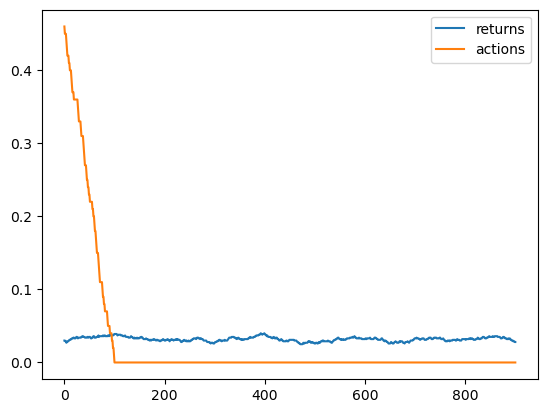

In [12]:
env = MultiArmedBandit(p_dist=[0.3, 0.1], r_dist=[0.1, 0.2])
agent = EpsilonFirstAgent(env, epsilon=0.1)
returns, Q_history, actions = agent.run()

# 시각화
import matplotlib.pyplot as plt
plt.plot(moving_average(returns), label='returns')
plt.plot(moving_average(actions), label='actions')
plt.legend()

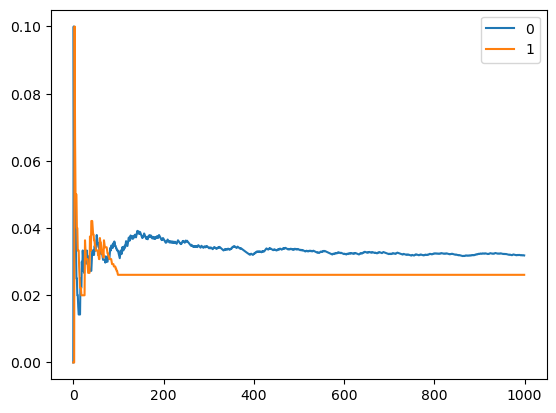

In [13]:
# 행동 가치 추정치의 변화
plt.plot(Q_history[:, 0], label='0')
plt.plot(Q_history[:, 1], label='1')
plt.legend()

## 입실론 탐욕법

In [6]:
class EpsilonGreedyAgent(EpsilonFirstAgent):
    def select_action(self, episode):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()  # 탐색
        else:
            return np.argmax(self.Q)  # 활용

100%|██████████| 1000/1000 [00:00<00:00, 132819.41it/s]


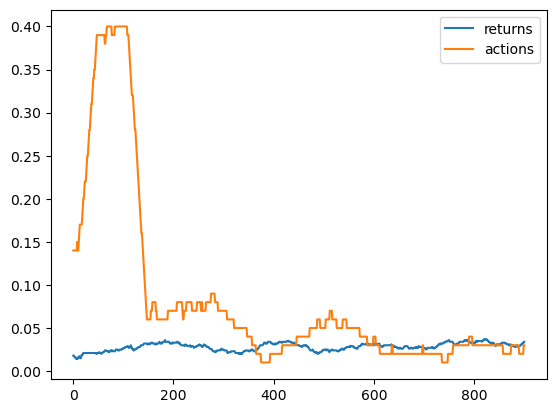

In [14]:
agent = EpsilonGreedyAgent(env, epsilon=0.1)
returns, Q_history, actions = agent.run()

# 시각화
plt.plot(moving_average(returns), label='returns')
plt.plot(moving_average(actions), label='actions')
plt.legend()

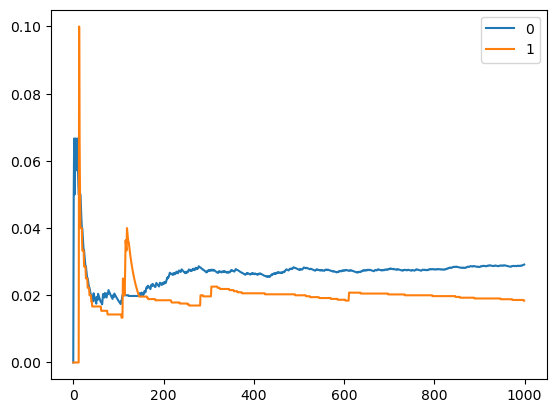

In [15]:
# 행동 가치 추정치의 변화
plt.plot(Q_history[:, 0], label='0')
plt.plot(Q_history[:, 1], label='1')
plt.legend()

### 감쇠 입실론 탐욕법 (선형적)

In [8]:
class LinearlyDecayingEpsilonGreedyAgent(EpsilonGreedyAgent):
    def __init__(self, env, initial_epsilon, min_epsilon, decay_rate, 
                 n_episodes=1000):
        super().__init__(env, initial_epsilon, n_episodes)
        self.initial_epsilon = initial_epsilon
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate
        self.epsilon = initial_epsilon
        self.total_steps = 0
        
    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon - self.decay_rate)

    def select_action(self, episode):
        self.decay_epsilon()
        self.total_steps += 1
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()  # 탐색
        else:
            return np.argmax(self.Q)  # 활용



100%|██████████| 1000/1000 [00:00<00:00, 79926.52it/s]

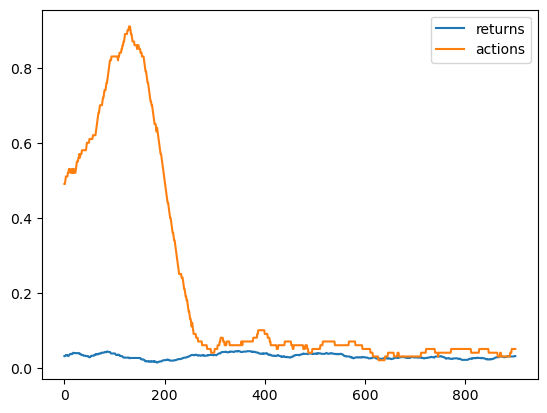

In [16]:
agent = LinearlyDecayingEpsilonGreedyAgent(env, initial_epsilon=0.8, min_epsilon=0.1, decay_rate=0.0035)
returns, Q_history, actions = agent.run()

# 시각화
plt.plot(moving_average(returns), label='returns')
plt.plot(moving_average(actions), label='actions')
plt.legend()

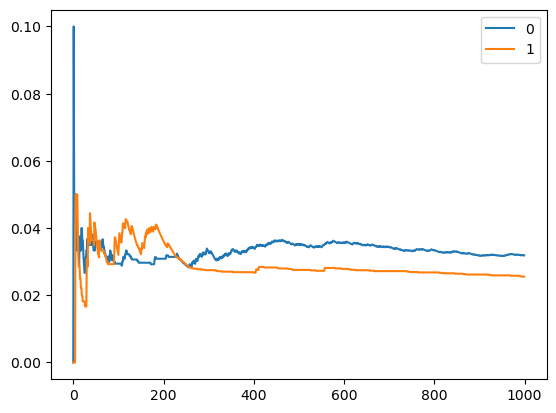

In [17]:
# 행동 가치 추정치의 변화
plt.plot(Q_history[:, 0], label='0')
plt.plot(Q_history[:, 1], label='1')
plt.legend()

### 감쇠 입실론 탐욕법 (지수적)

In [11]:
class ExponentialyDecayingEpsilonGreedyAgent(LinearlyDecayingEpsilonGreedyAgent):
    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * (1-self.decay_rate))


### 낙관적 초기화

In [18]:
class OptimisticInitializationAgent(EpsilonGreedyAgent):
    def __init__(self, env, optimistic_estimate, initial_count, n_episodes=1000):
        super().__init__(env, 0, n_episodes)
        self.optimistic_estimate = optimistic_estimate
        self.initial_count = initial_count
        self.Q = np.full(env.action_space.n, self.optimistic_estimate)
        self.N = np.full(env.action_space.n, self.initial_count, dtype=int)
        # Q는 낙관적 추정치로, N은 초기 값으로 채움

In [19]:
agent = OptimisticInitializationAgent(env, optimistic_estimate=0.05, initial_count=20)
returns, Q_history, actions = agent.run()

100%|██████████| 1000/1000 [00:00<00:00, 20664.14it/s]


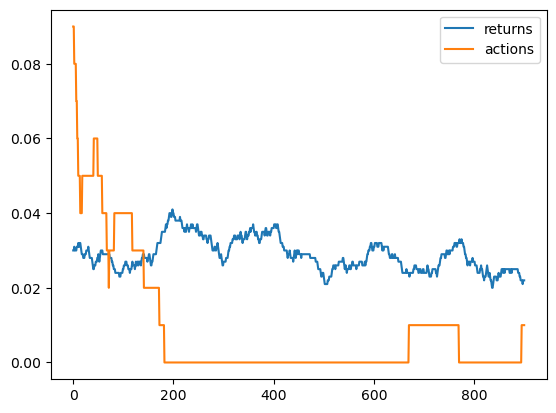

In [20]:
plt.plot(moving_average(returns), label='returns')
plt.plot(moving_average(actions), label='actions')
plt.legend()

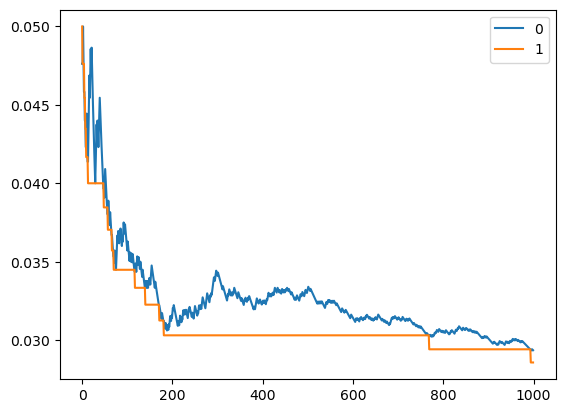

In [21]:
plt.plot(Q_history[:, 0], label='0')
plt.plot(Q_history[:, 1], label='1')
plt.legend()

## 소프트맥스 전략

In [22]:
class SoftMaxAgent(EpsilonGreedyAgent):
    def __init__(self, env, init_temp=10.0, min_temp=1e-32,
                 decay_ratio=0.02, n_episodes=1000):
        super().__init__(env, epsilon=0.0, n_episodes=n_episodes)
        self.temp = init_temp
        self.min_temp = min_temp
        self.temp_history = np.empty(n_episodes)
        self.decay_ratio = decay_ratio

    def select_action(self, episode):
        self.temp = max(self.temp * (1 - self.decay_ratio), self.min_temp)
        self.temp_history[episode] = self.temp
        scaled_Q = self.Q / self.temp
        norm_Q = scaled_Q - np.max(scaled_Q)  # 계산의 안정성을 위해
        exp_Q = np.exp(norm_Q)
        probs = exp_Q / np.sum(exp_Q)
        action = np.random.choice(np.arange(len(probs)), size=1, p=probs)[0]
        return action


In [23]:
agent = SoftMaxAgent(env)
returns, Q_history, actions = agent.run()

100%|██████████| 1000/1000 [00:00<00:00, 36188.68it/s]


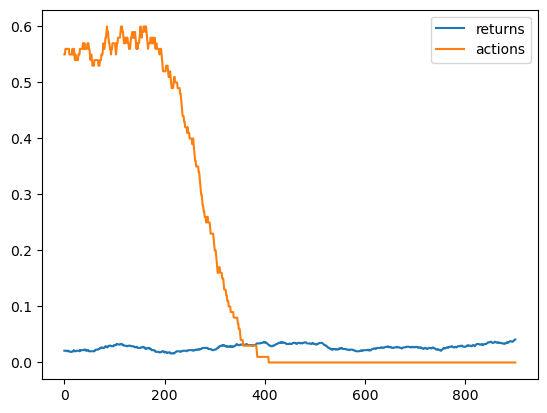

In [24]:
plt.plot(moving_average(returns), label='returns')
plt.plot(moving_average(actions), label='actions')
plt.legend()

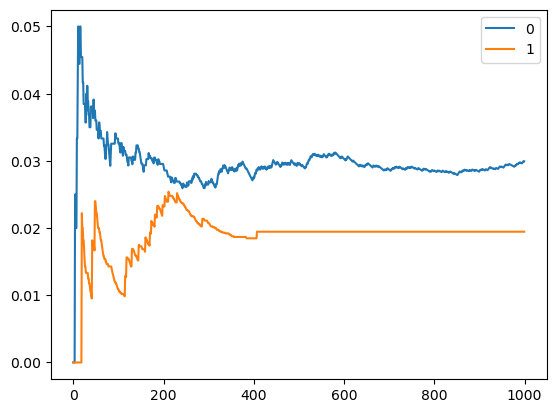

In [25]:
plt.plot(Q_history[:, 0], label='0')
plt.plot(Q_history[:, 1], label='1')
plt.legend()

## UCB

In [26]:
class UpperConfidenceBoundAgent(EpsilonGreedyAgent):
    def __init__(self, env, c=2, n_episodes=1000):
        super().__init__(env, epsilon=0.0, n_episodes=n_episodes)
        # epsilon은 사용되지 않으므로 0으로 설정
        self.c = c
        self.total_steps = 0

    def select_action(self, episode):
        if episode < len(self.Q):
            return episode  # 처음에는 각 행동을 한 번씩 선택
        else:
            # UCB 계산
            U = self.c * np.sqrt(np.log(episode + 1) / (self.N + 1e-5))
            return np.argmax(self.Q + U)  # UCB를 적용하여 행동 선택

In [27]:
agent = UpperConfidenceBoundAgent(env)
returns, Q_history, actions = agent.run()

100%|██████████| 1000/1000 [00:00<00:00, 76588.71it/s]


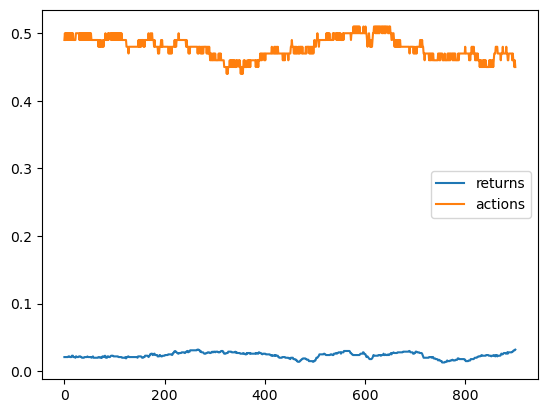

In [28]:
plt.plot(moving_average(returns), label='returns')
plt.plot(moving_average(actions), label='actions')
plt.legend()

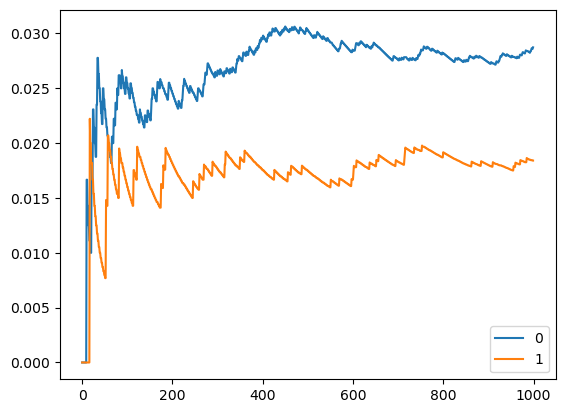

In [29]:
plt.plot(Q_history[:, 0], label='0')
plt.plot(Q_history[:, 1], label='1')
plt.legend()

## 톰슨 샘플링

In [30]:
class ThompsonSamplingAgent(EpsilonGreedyAgent):
    def __init__(self, env, alpha=1, beta=0, n_episodes=1000):
        super().__init__(env, epsilon=0.0, n_episodes=n_episodes)
        self.alpha = alpha
        self.beta = beta

    def select_action(self, episode):
        # 평균이 Q이고 표준편차가 sd인 정규분포에서 값을 하나씩 추출
        sd = self.alpha / (np.sqrt(self.N) + self.beta)
        samples = np.random.normal(loc=self.Q, scale=sd)
        return np.argmax(samples)  # 가장 큰 값이 나온 밴딧을 선택

In [31]:
agent = ThompsonSamplingAgent(env)
returns, Q_history, actions = agent.run()

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\eupho\AppData\Local\Temp\ipykernel_48804\1819746816.py:9: RuntimeWarning: divide by zero encountered in divide
  sd = self.alpha / (np.sqrt(self.N) + self.beta)
100%|██████████| 1000/1000 [00:00<00:00, 55341.86it/s]


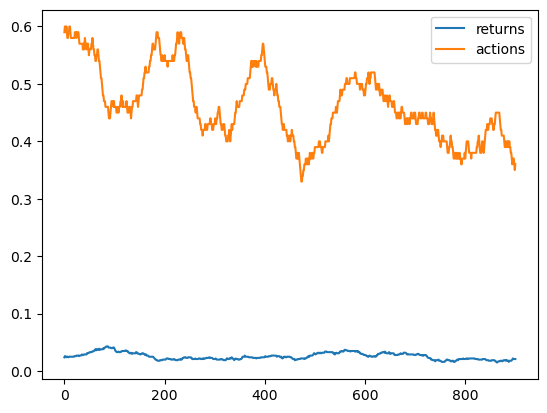

In [32]:
plt.plot(moving_average(returns), label='returns')
plt.plot(moving_average(actions), label='actions')
plt.legend()

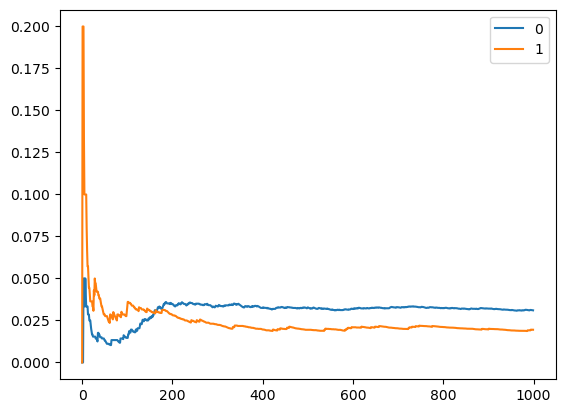

In [33]:
plt.plot(Q_history[:, 0], label='0')
plt.plot(Q_history[:, 1], label='1')
plt.legend()

## 퀴즈

<iframe src="https://tally.so/embed/wMLk0p?alignLeft=1&hideTitle=1&transparentBackground=1&dynamicHeight=1" loading="lazy" width="100%" height="1400" frameborder="0" marginheight="0" marginwidth="0" title="[RL] MAB"></iframe>